# 67P/Churyumov–Gerasimenko

This tutorial teaches you how to use the IAS15 integator (Rein and Spiegel, 2015) to simulate the orbit of 67P/Churyumov–Gerasimenko. We will download the data from NASA Horizons and visualize the orbit using matplotlib.

This tutorial assumes that you have already installed REBOUND.

## NASA Horizons

If you're interested in Solar System dynamics, you have probably heard of NASA Horizons. It's a large database of Solar System objects, their orbits and physical properties. It includes planets, moons, satellites, asteroids, comets and spacecrafts. With REBOUND, you can easily import data from NASA Horizons. As an example, let's pull in the present day positions of Jupiter, Saturn and the Sun:

In [1]:
import rebound
rebound.add("Sun")
rebound.add("Jupiter")
rebound.add("Saturn")

Searching NASA Horizons for 'Sun'... Found: Sun (10).
Searching NASA Horizons for 'Jupiter'... Found: Jupiter Barycenter (5).
Searching NASA Horizons for 'Saturn'... Found: Saturn Barycenter (6).


Now all the data is in REBOUND! Let's have a look at the orbits of the two planets.

In [2]:
for orbit in rebound.calculate_orbits():
    print(orbit)

<rebound.Orbit instance, a=5.20227733225 e=0.0488880899125>
<rebound.Orbit instance, a=9.54687500977 e=0.0539198219248>


Although there are three bodies, the `get_orbits()` function only returns two objects as the orbit for the Sun would be a little boring. The function returns the orbits in Jacobi coordinates. Since we didn't specify a falue for $G$, REBOUND assumes that $G=1$. The unit of length is one astronomical unit, the unit of time is one year/$2\pi$.

Let's add something more interesting to our simulation: the comet 67P/Churyumov-Gerasimenko. 

In [3]:
rebound.add("Churyumov-Gerasimenko")

Searching NASA Horizons for 'Churyumov-Gerasimenko'... Found: 67P/Churyumov-Gerasimenko.


When searching for a body by name, REBOUND takes the first dataset that Horizons offers. In this case, it's a set of parameters from 1962. You probably want to go to the Horizons website and check that the values you are using are up-to-date and appropriate for what you want to do. You can also use more complicted Horizons queries, for example, to get the most recent apparition solution for the comet, use

    rebound.add("NAME=Churyumov-Gerasimenko; CAP")

You can also use the IAU asteroid number for numbered asteroids, or the database record numbers from Horizons for objects not yet numbered by the IAU (but note that database record numbers can change as the database gets rearranged with new discoveries, see http://ssd.jpl.nasa.gov/?horizons_doc#sb for details). In our case the current database record number is 900647, so you could use `rebound.add("900647")` to get the newest set of orbital parameters for Churyumov-Gerasimenko.

NASA Horizons doesn't have masses for all bodies. If REBOUND doesn't find a mass, you get a warning message (see above). In our case, we don't need the mass of the comet (it's really smal). However, it you want, you can add it manually using the syntax `rebound.add("Churyumov-Gerasimenko", m=5.03e-18)`.

## Integration with IAS15
We will integrate backwards in time for 70 years. Because we don't know what will happen yet (hint: a close encounter) we will use the IAS15 integrator. It is fast, accurate and has adaptive timesteps to capture any potential close encounters. 

To integrate backwards, we could set a negative timestep or multiply all velocities with $-1$. We'll choose the first option:

In [4]:
rebound.dt = -0.01

While we're integrating, let's store the positions of Jupiter and the comet at 1000 times during the interval. We'll need to prepare a few variables to do that:

In [5]:
import numpy as np
Noutputs = 1000
year = 2.*np.pi # One year in units where G=1
times = np.linspace(0.,-70.*year, Noutputs)
x = np.zeros((2,Noutputs))
y = np.zeros((2,Noutputs))

Now we're ready to start the integration:

In [6]:
rebound.integrator = "ias15" # IAS15 is the default integrator, so we actually don't need this line
rebound.move_to_com() # We always move to the center of momentum frame before an integration
ps = rebound.particles  # ps is now an array of pointers and will change as the simulation runs

for i,time in enumerate(times):
    rebound.integrate(time)
    x[0][i] = ps[1].x   # This stores the data which allows us to plot it later
    y[0][i] = ps[1].y
    x[1][i] = ps[3].x
    y[1][i] = ps[3].y

## Visualization with matplotlib
Let's plot the orbits of Jupiter (blue) and the comet (green) to get an idea of what was going on during our integration.

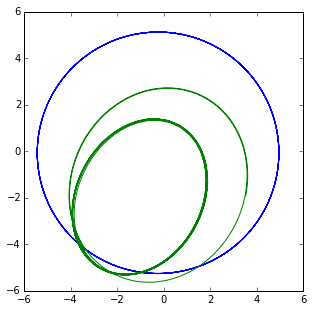

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
ax.set_xlim([-6,6])
ax.set_ylim([-6,6])
plt.plot(x[0], y[0]);
plt.plot(x[1], y[1]);

As you can see in the above image, the comet 67P had a rather strong encounter with Jupiter a few years ago. Of course, if you wanted to do a realistic simulation of that encounter, you'd need to include all the other planets and maybe even some non-gravitational effects for the comet. However, let's stick with our simplistic model and try to find out when exactly the two bodies had a close encouter. We already stored the data, so we can just plot their distance as a function of time.

Minimum distance (0.015721 AU) occured at time: -56.266266 years.


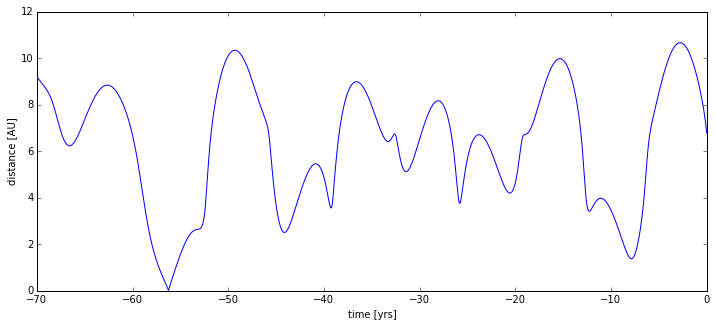

In [8]:
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
ax.set_xlabel("time [yrs]")
ax.set_ylabel("distance [AU]")
distance = np.sqrt(np.square(x[0]-x[1])+np.square(y[0]-y[1]))
plt.plot(times/year, distance);
closeencountertime = times[np.argmin(distance)]/year
print("Minimum distance (%f AU) occured at time: %f years." % (np.min(distance),closeencountertime))

We can see that the minimum distance occured approximately 56 years ago (as of writing this tutorial). Let's see what date that was using some python magic and the datetime module:

In [9]:
import datetime
encounterdate = datetime.datetime.today() + datetime.timedelta(days=365.25*closeencountertime)
encounterdate.strftime("%Y-%m-%d %H:%M")

'1959-02-08 16:24'

According our calculation, the close encounter happened in February 1959. If you check [wikipedia](http://en.wikipedia.org/wiki/67P/Churyumov–Gerasimenko) it turns out we are (at least approximately) right!